# Factuality of Large Language Models
Since they are trained to reproduce text, LLMs are not built to care about facts very much. This is a notebook to try out some huggingface features, get a better feeling of how well facts are represented and if that can be improved. This toy example uses LLMs from HuggingFace and relations between characters in the Harry Potter books.

## Questions
1. Do HF models know the books? Test by generating Text.
2. How is text generation implemented? More detailed look at the tokenizer, model structure and text generation function.
3. How to tell if the model knows the facts? Infer character relations from token prediction probabilities.

## References
- [Hugging Face Tutorial on Causal Language Modelling](https://huggingface.co/docs/transformers/en/tasks/language_modeling)
- Pythia Suite from Eleuther described in this article: [Pythia: A Suite for Analyzing Large Language Models Across Training and Scaling (2023)](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://arxiv.org/abs/2304.01373&ved=2ahUKEwiptvjlq-yFAxXQ2AIHHdbIDmsQFnoECAcQAQ&usg=AOvVaw1vz79Jf0Wj1Ohmo9eJp1R2)
- Hosted on [Hugging Face](https://huggingface.co/collections/EleutherAI/pythia-scaling-suite-64fb5dfa8c21ebb3db7ad2e1)
- Nice article on BPE and sampling strategies [From Jake Tae's blog](https://jaketae.github.io/study/gpt2/#setup)

# 0. HF Language Models from the Pythia Suite

- The Pythia models consist of "a suite of 16 LLMs all trained on public data seen in the exact same order and ranging in size from 70M to 12B parameters".
- They are "decoder-only autoregressive language models". I.e. the input is a sequence of text tokens, the outputs are logits for the likelihood of token ids which follow each token, and in particular the token which will follow the last token of the input sequence.
      

# 1. Generate text with a HF model

- A test on trainingsdata memorization: does a model correctly continue phrases from some well known books?
- The trainingsdata might have contained the whole book, or only phrases from discussions online.
- If the model doesn't reproduce the expected text, the prompt might be too short, the text sampling too random, or the model too small.
- Turns out the larger models can retrieve the context of the book, and sometimes even complete the quote correctly.
- The smaller the model, the less likely this is to work.

In [1]:
import pandas as pd 
import torch
# hugging face modules
from transformers import AutoTokenizer
from transformers import AutoModelForCausalLM

%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

In [2]:
# shortcuts for the model names, using eleu_xxs to eleu_xxxl
from utils import model2hfname

# this one is on the larger side
mkey = 'eleu_xl'
model_id = model2hfname[mkey]
print(model_id)

EleutherAI/pythia-2.8b


In [3]:
tokenizer = AutoTokenizer.from_pretrained(model_id, padding_side='left')
tokenizer.pad_token = tokenizer.eos_token

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [4]:
model = AutoModelForCausalLM.from_pretrained(model_id)

In [5]:
# how big is the model?

total_params = sum(p.numel() for p in model.parameters())
print(f'Model size [params]: {total_params:,}') # as advertised

Model size [params]: 2,775,208,960


In [6]:
prompts = ["In a hole in the ground there lived", #a hobbit. Not a nasty, dirty, wet hole, filled with the ends of worms and an oozy smell
           "When Mr. Bilbo Baggins of Bag End announced", #that he would shortly be celebrating his eleventy-first birthday
           "Mr. and Mrs. Dursley of number four, Privet Drive, were proud to say", #that they were perfectly normal, thank you very much.
           'Dumbledore turned and walked back down the street. On', # the corner he stopped and took out the silver Put-Outer.' 
          ]

In [7]:
model_inputs = tokenizer(prompts, return_tensors="pt", padding=True)
generated_ids = model.generate(**model_inputs,
                               pad_token_id=tokenizer.eos_token_id,
                               max_new_tokens=50,
                               num_beams=5, 
                               no_repeat_ngram_size=2,
                               num_return_sequences=1
                              )

for txt in tokenizer.batch_decode(generated_ids, skip_special_tokens=True):
    print('*** Example ***')
    print()
    print(txt)
    print()


*** Example ***

In a hole in the ground there lived a hobbit." "Not a nasty, dirty, wet hole, filled with the ends of worms and an oozy smell, nor yet a dry, bare, sandy hole with nothing in it to sit down on or to eat: it was a

*** Example ***

When Mr. Bilbo Baggins of Bag End announced that he had come to live in the Shire, it was a great day for the Hobbits, for it meant that they were no longer under the eye of the Dark Lord, Sauron, and his minions. It was also a

*** Example ***

Mr. and Mrs. Dursley of number four, Privet Drive, were proud to say that they were perfectly normal, thank you very much. They had no idea who any of the people in this book were."

"I don't understand," said Harry. "How can they be normal if they've never heard of Dumbled

*** Example ***

Dumbledore turned and walked back down the street. On the other side of the road, Harry and Hermione followed him.

"What was that all about?" Harry asked. "I thought you were going to tell me something important 

# 2. A quick look under the hood

## The tokenizer

- A byte pair encoding tokenizer.
- Most of the longer tokens are English words, so although the model can generate text in different languages, English is at an advantage.
- With about 50k different tokens, there is room for some quite long words represented by a single token.

In [8]:
type(tokenizer)

transformers.models.gpt_neox.tokenization_gpt_neox_fast.GPTNeoXTokenizerFast

In [9]:
vocab = tokenizer.get_vocab()
len(vocab)

50277

In [10]:
tokens = pd.DataFrame()
tokens['token'] = vocab.keys()
tokens['id'] = vocab.values()
tokens['token_raw'] = tokens['token'].str.replace('Ġ', '')
tokens['length'] = tokens['token_raw'].str.len()
tokens.sort_values(by='length', ascending=False, inplace=True)

<Axes: title={'center': 'Distribution of token length'}, xlabel='Number of characters', ylabel='Frequency'>

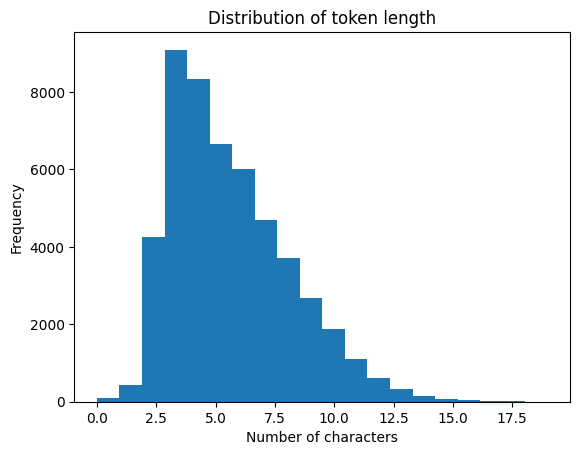

In [11]:
tokens[tokens['length'] < 20]['length'].plot.hist(bins=20, xlabel='Number of characters', title='Distribution of token length')


In [12]:
# Some examples of individual tokens
for pos in [150, 1000, 10_000, 30_000, 40_000, 50_000]:
    display(tokens.sort_values(by='length', ascending=False).head(pos).tail(3)[['token_raw', 'length', 'id']])

,token_raw,length,id
35811,gastrointestinal,16,22496
39865,misunderstanding,16,40663
375,cryptocurrencies,16,44923


,token_raw,length,id
9611,illustration,12,23356
22865,hypertension,12,14300
12451,formaldehyde,12,48306


,token_raw,length,id
29711,determin,8,11544
49211,argument,8,24058
49218,Criminal,8,20526


,token_raw,length,id
29985,sans,4,20155
25635,rank,4,5958
29958,publ,4,2958


,token_raw,length,id
34295,139,3,15470
20303,Dur,3,45865
20309,set,3,873


,token_raw,length,id
48111,",",1,1157
26466,Ñ,1,141
2778,±,1,111


## More details of the model suite's architecture

- From a table in the Pythia-paper, the number of model parameters is varied by choosing different meta parameter values for
    - hidden-size
    - num-attention-heads
    - num-layers
- This does not cover all the details. Looking some more into the article, the trace of references goes like this:
    - The article states: 'model architecture and hyperparameter largely follow Brown et al. (2020)' (article title: Language Models are Few-Shot Learners)
    - In there: 'We use the same model and architecture as GPT-2 ' (language models are unsupervised multitask learners, 2019)
    - From there: 'The model largely follows the details of the OpenAI GPT' (Language Models are Few-Shot Learners)
    - Which refers again: 'The model largely follows the details of the OpenAI GPT model' ('Improving language understanding by generative pre-training, 2018)
    - There, finally: 'Our model largely follows the original transformer work' ('Attention is all you need')!
- So there is no detailed description in one place, and it's probably best to look into the model or the code itself.

In [13]:
type(model)

transformers.models.gpt_neox.modeling_gpt_neox.GPTNeoXForCausalLM

In [14]:
print(model)

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 2560)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=2560, out_features=7680, bias=True)
          (dense): Linear(in_features=2560, out_features=2560, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=2560, out_features=10240, bias=True)
          (dense_4h_to_h): Linear(in_features=10240, out_features=2560, bias=True)


In [15]:
# => 12 transformer layers and one linear layer

In [16]:
final_layer = dict(model.named_modules())['embed_out']
final_layer

Linear(in_features=2560, out_features=50304, bias=False)

In [17]:
for p in final_layer.parameters():
    print(p.shape)

torch.Size([50304, 2560])


## Text generation

- There are many good explanations about the structure of transformer modules, so let's only look at how tokens are predicted in the final layer.
- A text "random words"  is tokenized to a list of token ids [1, 2, 3].
- The transformer layers return a list of embedding vectors [v1, v2, v3]
- The final de-embedding layer turns each vector in to logits for the tokens that are likely to follow the preceding sequence [l1, l2, l3], so that l1 encodes the likelihood of tokens following the id-sequence [1], (hopefully with a maximum at id 2) l2 the likelihood of tokens following the sequence [1, 2] (hopefully maximal at 3] and l3 the expected tokens after [1, 2, 3] (which is the only one relevant for continuing the sequence) 


In [18]:
prompt = "hello world what is"


In [19]:
# tokenize the prompt

encoded_input = tokenizer(prompt, return_tensors='pt')
encoded_input

{'input_ids': tensor([[25521,  1533,   752,   310]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

In [20]:
# predict some new tokens

generated_output = model.generate(**encoded_input)
generated_output

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
/home/volker/code/dpo_projektle/.venv_hf/lib/python3.11/site-packages/transformers/generation/utils.py:1133: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


tensor([[25521,  1533,   752,   310,   253,  4495,   273,   436,  2127,    32,
           187,   187,    34,    27,   187,   187,   510,  2127,   310,   247]])

In [21]:
# which can be decoded to text with the tokenizer

tokenizer.decode(generated_output[0])

'hello world what is the meaning of this code?\n\nA:\n\nThe code is a'

In [22]:
# manual prediction: pass the tokens through the model

model_output = model(**encoded_input, output_hidden_states=True)
print('Output object class:', type(model_output))
# can check here: https://huggingface.co/docs/transformers/en/main_classes/output
print('Output components:', model_output.keys())

Output object class: <class 'transformers.modeling_outputs.CausalLMOutputWithPast'>
Output components: odict_keys(['logits', 'past_key_values', 'hidden_states'])


In [23]:
# the model's attention layers produce increasingly mixed lists of sequences of embeddings.

In [24]:
hidden_states = model_output['hidden_states']
print('Total module outputs', len(hidden_states))
# each one has the same shape (batchsize, sequence_length, embedding_dimension)
print(hidden_states[-1].shape)

Total module outputs 33
torch.Size([1, 4, 2560])


In [25]:
# the last sequence of embeddings is passed through the linear layer for a prediction of the next tokens.
# Given embeddings for tokens 1..n, the model predicts tokens 2...n+1
# Each embedding is passed individually throug the linear layer. 
# Therefore, in order to predict the following token for each embedding in the last module, the embeddings do not encode
# the meaning of each token individually, but all information from the sequence of previous tokens

logits = model_output['logits']
logits.shape

torch.Size([1, 4, 50304])

In [26]:
# these are the most likely token ids, given the logits
next_token = torch.argmax(logits, dim=2)
next_token.numpy()

array([[  3,   3, 310, 253]])

In [27]:
tokenizer.decode(list(next_token.numpy()[0]))

'"" is the'

In [28]:
# we see the predicted tokens given parts of the sequence are
# hello => !
# hello world => !
# hello world what => is
# hello world what is => the
# the final token (253) is the next token in the sequence, and is consistent with the generate function

# Test factuality

- Create a number of 'facts' describing the 'relation' between various Harry Potter Books' characters (Some of these are debatable, but let's not worry about it too much)
- Then test if the correct facts are assigned higher scores by the model than the opposites (fiction) 

In [29]:
from utils import load_relations

relations = load_relations()
relations.head()

,first,second,first_side,second_side,chosen,rejected,prompt,fact,fiction
327,Severus Snape,Gilderoy Lockhart,0,0,friend,enemy,Severus Snape is Gilderoy Lockhart's,Severus Snape is Gilderoy Lockhart's friend,Severus Snape is Gilderoy Lockhart's enemy
30,Bellatrix Lestrange,Neville Longbottom,0,1,enemy,friend,Bellatrix Lestrange is Neville Longbottom's,Bellatrix Lestrange is Neville Longbottom's enemy,Bellatrix Lestrange is Neville Longbottom's fr...
820,Rubeus Hagrid,Cho Chang,1,1,friend,enemy,Rubeus Hagrid is Cho Chang's,Rubeus Hagrid is Cho Chang's friend,Rubeus Hagrid is Cho Chang's enemy
404,Gellert Grindelwald,Cedric Diggory,0,1,enemy,friend,Gellert Grindelwald is Cedric Diggory's,Gellert Grindelwald is Cedric Diggory's enemy,Gellert Grindelwald is Cedric Diggory's friend
76,Dolores Umbridge,Molly Weasley,0,1,enemy,friend,Dolores Umbridge is Molly Weasley's,Dolores Umbridge is Molly Weasley's enemy,Dolores Umbridge is Molly Weasley's friend


In [67]:
## To visualize the relations one can plot a graph of the characters as nodes and their relationship as edge
# in this simple world, there is the good camp and the bad camp, and everybody is friend within their own camp, but enemy with all members of the other camp.

from utils import plot_graph, graph_positions

positions = graph_positions(relations)

plot_graph(positions, relations, column='chosen')

In [38]:
# first of all, has the model read about Harry potter? (could be the book, or online content)
encoded_input = tokenizer("Harry Potter's goes to school at", return_tensors='pt')
generated_output = model.generate(**encoded_input, max_length=20)
print(tokenizer.decode(generated_output[0]))

encoded_input = tokenizer("Harry Potter's friends are Ron", return_tensors='pt')
generated_output = model.generate(**encoded_input, max_length=20)
print(tokenizer.decode(generated_output[0]))

# => More or less.

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Harry Potter's goes to school at Hogwarts, and Harry Potter's goes to school at Hog
Harry Potter's friends are Ron and Hermione, who are both in their early twenties. They


In [72]:
# now calculate the score of the fact from the model's output logits
fiction = relations.iloc[1]['fiction'] # for later
fact = relations.iloc[1]['fact']
print(fact, '|', fiction)
encoded_input = tokenizer(fact, return_tensors='pt')
model_output = model(**encoded_input, output_hidden_states=True)
print(model_output.keys())

Bellatrix Lestrange is Neville Longbottom's enemy | Bellatrix Lestrange is Neville Longbottom's friend
odict_keys(['logits', 'past_key_values', 'hidden_states'])


In [40]:
# for each input token...
encoded_input['input_ids'].shape

torch.Size([1, 12])

In [41]:
# predictions are assigned to the following token
logits = model_output['logits'][0, :, :]
logits.shape

torch.Size([12, 50304])

In [42]:
# these are the token ids of the sentence
# and we need to shift by one and drop last token (which is the prediction of the word following our fact)
labels = encoded_input['input_ids'][:, 1:]
labels

tensor([[28491,   418,   383,  6324,   310, 16393,  4002,  8057, 10492,   434,
          9054]])

In [43]:
# to find the logits of the actually appearing tokens

per_token_logps = torch.gather(logits[:, 0:-1], dim=1, index=labels.T)

per_token_logps


tensor([[ 2.3523],
        [ 9.5285],
        [14.0712],
        [18.8797],
        [12.1508],
        [ 5.2060],
        [22.4017],
        [16.1292],
        [19.2569],
        [17.8785],
        [ 8.4963]], grad_fn=<GatherBackward0>)

In [44]:
# double check it is gathered correctly

second_id = labels[0, 1]
print(second_id)
logits[1, second_id]


tensor(418)


tensor(9.5285, grad_fn=<SelectBackward0>)

In [45]:
# double check what is done here: the labels are the original fact tokens, without the first one.
tokenizer.decode(labels[0, :])

"atrix Lestrange is Neville Longbottom's enemy"

In [46]:
# ... these are the tokens that the model would predict, given the logits ...
next_token = torch.argmax(logits, dim=1)
next_token

tensor([   13,    13,   383,  6324,    13,   247,  4002,   434, 10492,   434,
         3101,    13])

In [47]:
# ... and those are the decoded tokens
tokenizer.decode(next_token) 
# => logits predict the probability of not the current, but the next token:

",,estrange, aille'sbottom's mother,"

In [74]:
# collect this code in a function

def fact_score(fact, model, tokenizer, softmax=False):
    encoded_input = tokenizer(fact, return_tensors='pt')
    model_output = model(**encoded_input, output_hidden_states=True)
    logits = model_output['logits'][0, :, :]
    # need to shift by one for predictions
    labels = encoded_input['input_ids'][:, 1:]
    if softmax:
        logits = logits.softmax(-1)
    # collect the log probabilities for the labels, drop last token which is the prediction of the word following our fact
    per_token_logps = torch.gather(logits[:, 0:-1], dim=1, index=labels.T)
    print(per_token_logps)
    score = per_token_logps.sum()
    return score.item()

fact_score(fact, model, tokenizer, softmax=False), fact_score(fiction, model, tokenizer, softmax=False)
# we see that only the score for the final token (enemy/friend) is different

tensor([[ 2.3523],
        [ 9.5285],
        [14.0712],
        [18.8797],
        [12.1508],
        [ 5.2060],
        [22.4017],
        [16.1292],
        [19.2569],
        [17.8785],
        [ 8.4963]], grad_fn=<GatherBackward0>)
tensor([[ 2.3523],
        [ 9.5285],
        [14.0712],
        [18.8797],
        [12.1508],
        [ 5.2060],
        [22.4017],
        [16.1292],
        [19.2569],
        [17.8785],
        [10.5976]], grad_fn=<GatherBackward0>)


(146.3512420654297, 148.45249938964844)

In [53]:
# let's pick only a few examples to save time.
test = relations.sample(n=50, random_state=42)

In [54]:
test['fact_score'] = test['fact'].apply(lambda f: fact_score(f, model, tokenizer))
test['fiction_score'] = test['fiction'].apply(lambda f: fact_score(f, model, tokenizer))

In [56]:
test.head()

,first,second,first_side,second_side,chosen,rejected,prompt,fact,fiction,fact_score,fiction_score,correct
478,Gilderoy Lockhart,Lee Jordan,0,1,enemy,friend,Gilderoy Lockhart is Lee Jordan's,Gilderoy Lockhart is Lee Jordan's enemy,Gilderoy Lockhart is Lee Jordan's friend,88.623856,90.393066,False
728,Harry Potter,Nymphadora Tonks,1,1,friend,enemy,Harry Potter is Nymphadora Tonks's,Harry Potter is Nymphadora Tonks's friend,Harry Potter is Nymphadora Tonks's enemy,137.432541,133.116638,True
138,Barty Crouch Jr.,Gregory Goyle,0,0,friend,enemy,Barty Crouch Jr. is Gregory Goyle's,Barty Crouch Jr. is Gregory Goyle's friend,Barty Crouch Jr. is Gregory Goyle's enemy,104.408287,102.048744,True
375,Fenrir Greyback,Ginny Weasley,0,1,enemy,friend,Fenrir Greyback is Ginny Weasley's,Fenrir Greyback is Ginny Weasley's enemy,Fenrir Greyback is Ginny Weasley's friend,129.731781,132.356674,False
88,Lord Voldemort,Draco Malfoy,0,0,friend,enemy,Lord Voldemort is Draco Malfoy's,Lord Voldemort is Draco Malfoy's friend,Lord Voldemort is Draco Malfoy's enemy,185.150406,184.898865,True


In [57]:
test['correct'] = test['fact_score'] > test['fiction_score']
test['chosen_model'] = test.apply(lambda row: row['chosen'] if row['correct'] else row['rejected'], axis=1)

## How good is the models estimation of the relations?

In [76]:
test['correct'].mean()

0.52

In [ ]:
# not that good, apparently

In [58]:
test['chosen_model'].value_counts()

chosen_model
friend    50
Name: count, dtype: int64

In [81]:
# the model just prefers everybody to be friendly

In [68]:
# can also plot this graph
plot_graph(positions, test, column='chosen_model', title='Relations as chosen by the model')

## Well, this is a bit disappointing. The model's relationship prediction doesn't depend much on the characters.

In [82]:
encoded_input = tokenizer("Lord Voldemort is Harry Potter's", return_tensors='pt')
generated_output = model.generate(**encoded_input, max_length=20)
print(tokenizer.decode(generated_output[0]))

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Lord Voldemort is Harry Potter's father.

Harry Potter is a wizard.



### Double checking, yes, relations are hallucinated.
### One could try to find a more neutral way to formulate the facts, but maybe one can also force the model to learn by fine-tuning the pretrained?